In [2]:
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results

class MarketSimEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, s0, b, T, v, q0, c0, sigma, drift, gamma, itp, os, tf, k, A):
        '''
        Description:
            A basic market simulator environment.

        Action space:
            Managing the spread

        Observation space:
            Current price, inventory of the market making agent and current step/minute within the episode/day

        Parameters:
            s0 (float):             Initial stock price
            T (float):              Episode duration
            q0 (float):             Initial inventory
            c0 (float):             Initial cash on hand
            sigma (float):          Price volatility
            drift (float):          Price drift
            gamma (float):          Discount factor
            itp (float):            Percentage of Informed traders
            os (float):             Optimal spread wanted
            tf (float):             Trading frequency by investors

            v (float):              Verbose

            b (float):              Initial value of brecha
            k (float): In Avellaneda k = alpha*K, where alpha around 1.5
            A (float): In Avellaneda A = lamdba alpha where alpha is above and lambda is constant frequency of market buy and sell orders
        '''
        super().__init__()
        self.s0 = s0
        self.brecha = b
        self.episode_duration = T
        self.verbose = v

        self.initial_inventory = q0
        self.initial_cash = c0

        self.sigma = sigma
        self.drift = drift
        self.gamma = gamma

        self.itp = itp
        self.os = os
        self.tf = tf

        self.k = k
        self.A = A

        # Observation space
        self.observation_space = gym.spaces.Box(low=np.array([0.0, -math.inf, 0.0]),
            high = np.array([math.inf, math.inf, T]),
            dtype=np.float32)

        # Action space
        actions_num = 21
        self.action_space = gym.spaces.Discrete(actions_num)

        self._initiate_price_path()

    def reset(self, seed=None, option=None):
        super().reset(seed=seed)
        self.minute = 0
        self.price_path = []
        self.inventory = self.initial_inventory
        self.cash = self.initial_cash
        self.cum_rew = 0
        self.current_price = self.s0
        self.last_portfolio_value = self.inventory * self.current_price + self.cash
        self._initiate_price_path()
        return self._get_observation(), {}


    def step(self, action):
        # Update the current price
        self.current_price = self.price_path[self.minute]

        # Map the discrete action to a spread change
        self.spread = action / 4.0  # Map action to [-1, 1] and then adjust spread accordingly

        bid_price = self.current_price - self.spread / 2
        ask_price = self.current_price + self.spread / 2

        # Simulate market reaction to the bid and ask prices
        self._simulate_market(bid_price, ask_price)

        self.minute += 1
        reward = self._calculate_reward()
        done = self.minute >= self.episode_duration

        return self._get_observation(), reward, done, False,{}

    def _get_observation(self):
        return np.array([self.current_price, self.inventory, self.minute], dtype=np.float32)

    def _initiate_price_path(self):
        dt = 1 / self.episode_duration
        self.price_path = [self.s0]
        for _ in range(1, self.episode_duration):
            random_shock = np.random.normal(0, self.sigma * np.sqrt(dt))
            price_change = self.drift * dt + random_shock
            new_price = self.price_path[-1] * np.exp(price_change)
            self.price_path.append(new_price)

    def _simulate_market(self, bid_price, ask_price):
        # Determine the type of trader (informed or uninformed) using Poisson process
        trade_occurrence = np.random.poisson(self.tf)

        for _ in range(trade_occurrence):
            amount = np.random.randint(1, 10)

            if np.random.rand() < self.itp:
                # Informed trader makes a trade
                self._execute_informed_trade(bid_price, ask_price, amount)
            else:
                # Uninformed trader makes a trade
                self._execute_noise_trade(bid_price, ask_price, amount)

    def _execute_informed_trade(self, bid_price, ask_price, amount):
        true_value = self.price_path[self.minute + 1] if self.minute + 1 < self.episode_duration else self.current_price
        if true_value > ask_price: # Buy Informed Trade
            self.inventory -= amount
            self.cash += amount * ask_price
        elif true_value < bid_price: # Sell Informed Trade
            self.inventory += amount
            self.cash -= amount * bid_price

    def _execute_noise_trade(self, bid_price, ask_price, amount):
        if np.random.rand() < 0.5: # Buy Noise Trade
            self.inventory -= amount
            self.cash += amount * ask_price
        else:
            self.inventory += amount # Sell Noise Trade
            self.cash -= amount * bid_price

    def _calculate_reward(self):
        # PnL Change
        current_portfolio_value = self.inventory * self.current_price + self.cash
        pnLReward = current_portfolio_value - self.last_portfolio_value
        self.cum_rew += pnLReward
        self.last_portfolio_value = current_portfolio_value

        # Penalties
        inventory_penalty = 0.1 * np.abs(self.inventory - self.initial_inventory)

        return pnLReward - inventory_penalty


    def render(self):
            print(f"Spread: {self.spread}, Price: {self.current_price}, Cash: {self.cash}, Inventory: {self.inventory} Last reward: {self.cum_rew}")

In [3]:


env = MarketSimEnv(
    s0=100,
    b=0,
    T=240,
    v=True,
    q0=0,
    c0=10_000,
    sigma=0.1,
    drift=0.0001,
    gamma=.99,
    itp=0.1,
    os=0.02,
    tf=0.5,
    k=1.5,
    A=10)

env = Monitor(env, './logs')  # Use the Monitor wrapper

check_env(env)

model = DQN('MlpPolicy', env, verbose=1, exploration_fraction=0.5)
model.learn(total_timesteps=100_000)



Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 240      |
|    ep_rew_mean      | -274     |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5289     |
|    time_elapsed     | 0        |
|    total_timesteps  | 960      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 19.5     |
|    n_updates        | 214      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 240      |
|    ep_rew_mean      | -159     |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4759     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1920     |
| train/              |          |
|    learning_rate    | 0.0001   |
|  

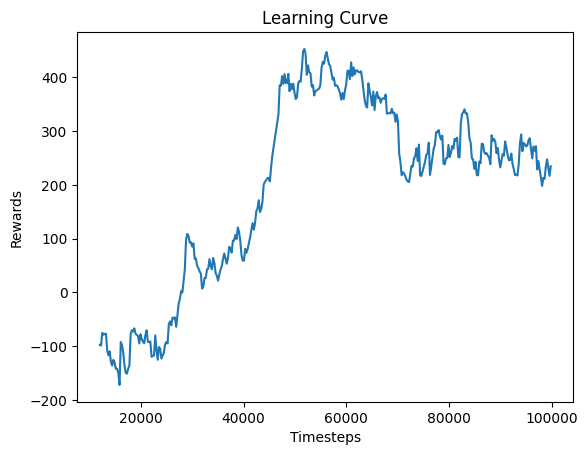

In [5]:
# Load results and plot
def plot_results(log_folder, title='Learning Curve'):
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = np.convolve(y, np.ones(50)/50, mode='valid')  # Moving average
    x = x[len(x) - len(y):]  # Trim x to match y length after convolution
    plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Timesteps')
    plt.ylabel('Rewards')
    plt.title(title)
    plt.show()

plot_results('logs/')

In [6]:
def plot_results(log_folders, labels, title='Learning Curve'):
    plt.figure(title)
    for log_folder, label in zip(log_folders, labels):
        x, y = ts2xy(load_results(log_folder), 'timesteps')
        y = np.convolve(y, np.ones(50)/50, mode='valid')  # Moving average
        x = x[len(x) - len(y):]  # Trim x to match y length after convolution
        plt.plot(x, y, label=label)
    plt.xlabel('Timesteps')
    plt.ylabel('Rewards')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:

parameters = [
    {'s0': 100, 'b': 0, 'T': 240, 'v': True, 'q0': 0, 'c0': 10000, 'sigma': 0.2, 'drift': 0.0001, 'gamma': 0.99, 'itp': 0.1, 'os': 0.02, 'tf': 0.5, 'k': 1.5, 'A': 10},
    {'s0': 100, 'b': 0, 'T': 240, 'v': True, 'q0': 0, 'c0': 10000, 'sigma': 0.2, 'drift': 0.0001, 'gamma': 0.99, 'itp': 0.6, 'os': 0.02, 'tf': 0.5, 'k': 1.5, 'A': 10},
    # Add more parameter sets here
]
log_dirs = ['./logs/m3/', './logs/m4/']
labels = ['Sigma 0.2', 'Sigma 0.4']

for param, log_dir in zip(parameters, log_dirs):
    env = MarketSimEnv(**param)
    env = Monitor(env, log_dir)
    check_env(env)

    model = DQN('MlpPolicy', env, verbose=1, exploration_fraction=0.2)
    model.learn(total_timesteps=100_000)

#plot_results(log_dirs, labels)

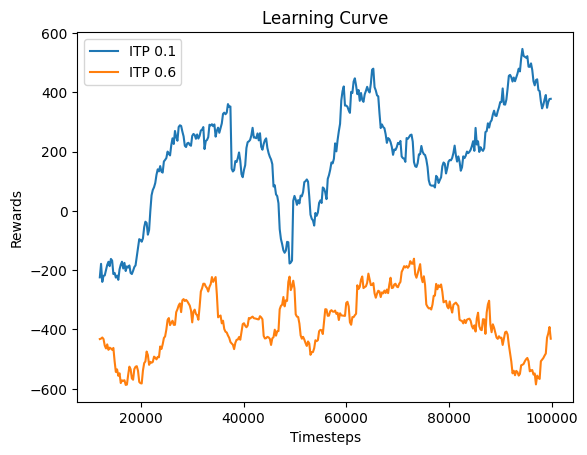

In [21]:
labels = ['ITP 0.1', 'ITP 0.6']
plot_results(['./logs/m3', './logs/m4'], labels)

In [ ]:

parameters = [
    {'s0': 100, 'b': 0, 'T': 240, 'v': True, 'q0': 0, 'c0': 10000, 'sigma': 0.2, 'drift': 0.0001, 'gamma': 0.99, 'itp': 0.1, 'os': 0.02, 'tf': 1, 'k': 1.5, 'A': 10},
    {'s0': 100, 'b': 0, 'T': 240, 'v': True, 'q0': 0, 'c0': 10000, 'sigma': 0.25, 'drift': 0.0001, 'gamma': 0.99, 'itp': 0.2, 'os': 0.02, 'tf': 0.5, 'k': 1.5, 'A': 10},
    # Add more parameter sets here
]
log_dirs = ['./logs/liquid/', './logs/illiquid/']
labels = ['Liquid market', 'Illiquid']

for param, log_dir in zip(parameters, log_dirs):
    env = MarketSimEnv(**param)
    env = Monitor(env, log_dir)
    check_env(env)

    model = DQN('MlpPolicy', env, verbose=1, exploration_fraction=0.2)
    model.learn(total_timesteps=100_000)

#plot_results(log_dirs, labels)

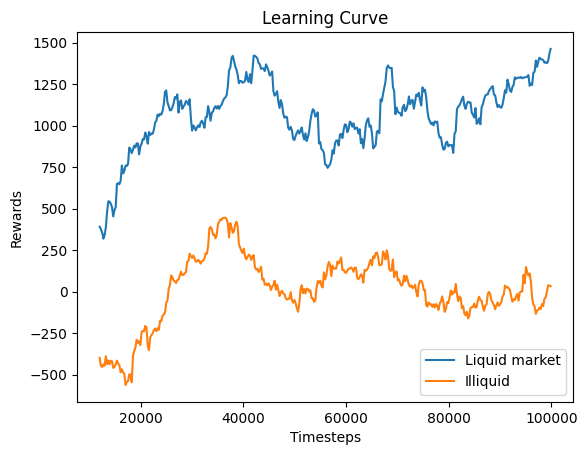

In [23]:
labels = ['Liquid market', 'Illiquid']
plot_results(['./logs/liquid', './logs/illiquid'], labels)